In [126]:
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.transforms import ToTensor, Compose, Resize, Normalize
from torch.utils.data import DataLoader, Dataset
import torch
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import os
import tqdm
from PIL import Image
from model import MiniUnet
from dit import DiTModel

from rectifiedflow import RectifiedFlow
import numpy as np


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
dataset1= MNIST(
    root='./data',
    train=True,
    download=True,
    transform=Compose([Resize([16,16]),ToTensor()])
)
dataset2=FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=Compose([Resize([16,16]),ToTensor()])
)
test_dataset = MNIST(
    root='./data',
    train=False,
    download=True,
    transform=Compose([Resize([16,16]),ToTensor()])
)

In [3]:
class CoupleMNIST(Dataset):
    def __init__(self, dataset1, dataset2, transform=None):
        self._pair_dict = {}
        self.transform = transform
        for i in range(len(dataset1.classes)):
            data1 = dataset1.data[dataset1.targets==i]
            data2 = dataset2.data[dataset2.targets==(i+1)%len(dataset1.classes)]
            self._pair_dict[i]={'m1':data1,'m2':data2,'tag':dataset1.classes[i]+'->'+dataset2.classes[i]}
        self.gen_data()

    def gen_data(self):
        data = []
        for k, v in self._pair_dict.items():
            common_len = min(v['m1'].shape[0],v['m2'].shape[0])
            data.append(torch.stack([v['m1'][:common_len],v['m2'][:common_len]],1)) # Nk*2*28*28
        self.data = torch.cat(data,0)

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        imgs = self.data[index]
        img1 = Image.fromarray(imgs[0].numpy(), mode="L")
        img2 = Image.fromarray(imgs[1].numpy(), mode="L")
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return torch.stack([img1,img2],0) 

In [96]:
dataset = CoupleMNIST(dataset1=dataset1,dataset2=dataset2, transform=Compose([ToTensor()]))

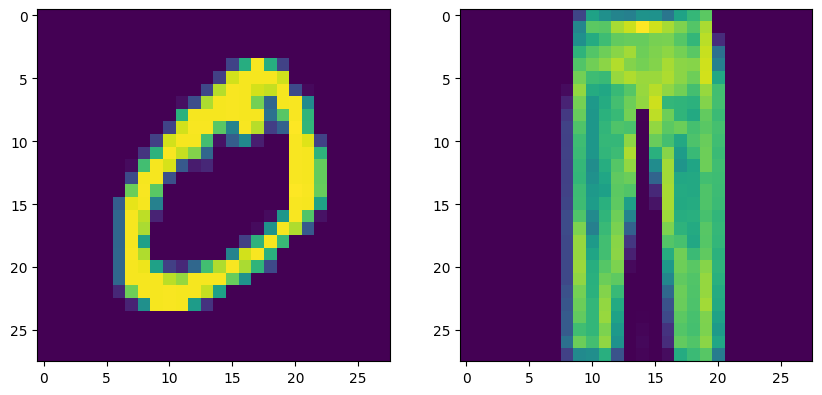

In [97]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(dataset[0][0,0])
plt.subplot(1, 2, 2)
plt.imshow(dataset[0][1,0])


In [ ]:
epochs = 3000
base_channels=128
lr_adjust_epoch = 100
batch_size = 32
lr = 1e-4
checkpoint_interval=10

exp_name='mnist2fashionmnist'
save_path = './ckps'
# model = MiniUnet(base_channels)
model = DiTModel(1,28,base_channels,2,1,8,4,6)
model.to(device)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle= True)
# 优化器加载 Rectified Flow的论文里面有的用的就是AdamW
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.1)

# 学习率调整
scheduler = StepLR(optimizer, step_size=lr_adjust_epoch, gamma=0.1)

# RF加载
rf = RectifiedFlow(model=model, num_steps=100)
# 记录训练时候每一轮的loss
loss_list = []

# 一些文件夹提前创建
os.makedirs(save_path, exist_ok=True)


# 训练循环
with tqdm.trange(epochs) as p:
    for epoch in p:
        for batch, data in enumerate(dataloader):
            optimizer.zero_grad()
            data = data.to(device)
            x_t, t, target = rf.get_train_tuple(z1=data[:,1], z0=data[:,0])
            pred = rf.model(x_t, t)
            loss = (target - pred).view(pred.shape[0], -1).abs().pow(2).mean()
            
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
        p.set_postfix(loss=np.mean(loss_list[-10:]))
        scheduler.step()
        if epoch % checkpoint_interval == 0 and epoch !=0:
            torch.save(model.state_dict(),f'{save_path}/{exp_name}_{epoch}_{np.mean(loss_list[-10:])}.ckpt')



  1%|▌                                                                                                                 | 16/3000 [12:51<41:06:38, 49.60s/it, loss=0.00802]

Text(0.5, 1.0, 'Training Loss Curve')

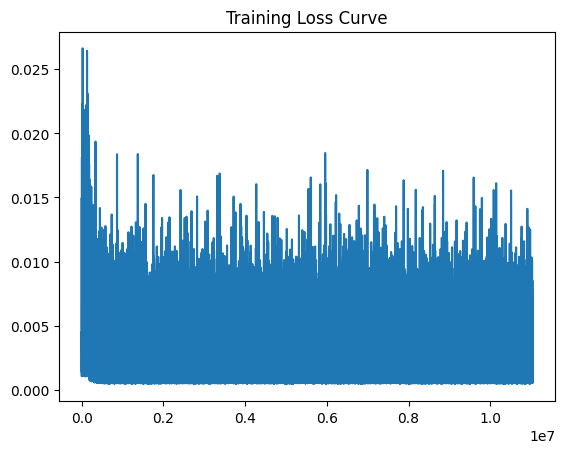

In [91]:
plt.plot(loss_list)
plt.title('Training Loss Curve')

In [124]:
z0z1=dataset[11500]
traj = rf.sample_ode(z0z1[:1].to(device),100)

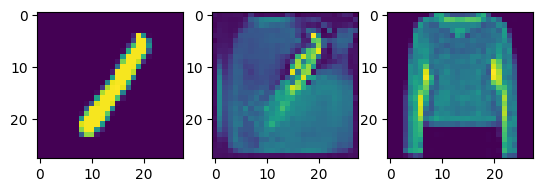

In [125]:
plt.subplot(1,3,1)
plt.imshow(z0z1[0,0].numpy())
plt.subplot(1,3,2)
plt.imshow(traj[100][0,0].cpu().numpy())
plt.subplot(1,3,3)
plt.imshow(z0z1[1,0].numpy())

In [102]:
z0=test_dataset[15][0]
# rf = RectifiedFlow(model=rf.model, num_steps=100)
traj = rf.sample_ode(z0.to(device).unsqueeze(0),100)

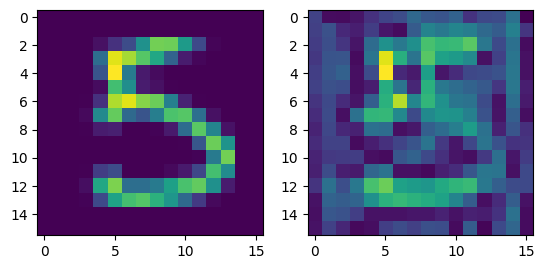

In [103]:
plt.subplot(1,2,1)
plt.imshow(z0[0].numpy())
plt.subplot(1,2,2)
plt.imshow(traj[100][0,0].cpu().numpy())
